### Encoding categorical variables:
- Nominal -> OneHotEncoder
- Ordinal -> LabelEncoder

In [29]:
import numpy as np;
import pandas as pd;
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import StandardScaler, OneHotEncoder;
from sklearn.compose import ColumnTransformer;

In [30]:
# Load dataset
data = pd.read_csv('../data/adult_income.csv');

In [31]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [32]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [33]:
# Basic preprocessing
data = data.dropna();  # Handle missing values by dropping rows with missing values?
X = data.drop('income', axis=1); # features
y = data['income']; # target

# Encoding categorical variables and scalling numerical ones
categorical_features = ['gender', 'occupation', 'education'];
numeric_features = ['age', 'hours-per-week'];

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

X = preprocessor.fit_transform(X);

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

In [34]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5, scoring='roc_auc', verbose=2
                           )
grid_search.fit(X_train, y_train)

# Evaluation the best model

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(f"\n Classification Report:\n {classification_report(y_test, y_pred)}")
print(f"\n Best AUC-ROC:\n {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  16.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  33.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  33.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  33.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  32.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  32.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=  49.8s
[CV] END max_depth=None, 

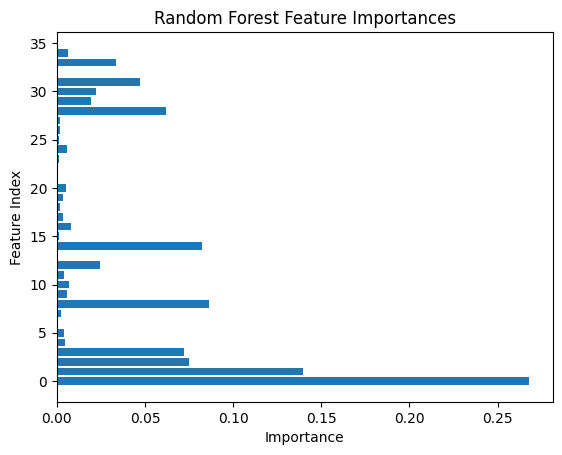

In [36]:
# Feature Importance Visualization

import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
plt.barh(range(len(importances)), importances)
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.title('Random Forest Feature Importances')
plt.savefig('../artifacts/figures/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

- ### XGBoost Implementation

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=5, scoring='roc_auc', n_iter=50, random_state=42)
random_search.fit(X_train, y_train)

# Evaluate the best model
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:23:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:23:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:23:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:23:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:7

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7479
           1       0.67      0.48      0.56      2290

    accuracy                           0.82      9769
   macro avg       0.76      0.70      0.72      9769
weighted avg       0.81      0.82      0.81      9769



- ### Comparing Model Performance

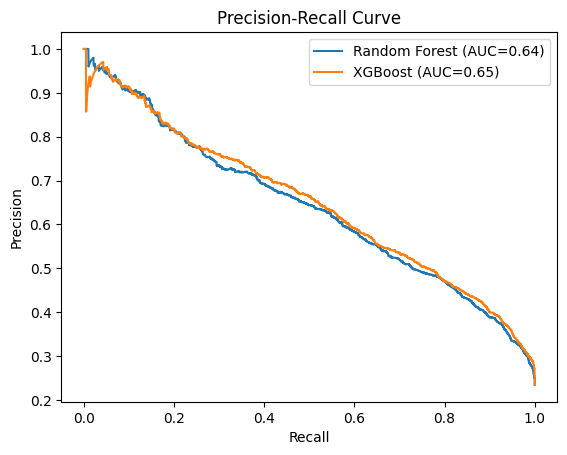

Random Forest AUC-ROC: 0.84, F1 Score: 0.50
XGBoost AUC-ROC: 0.85, F1 Score: 0.56


In [44]:
# Evaluation Metrics
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc;
import matplotlib.pyplot as plt;

# Prediction and probabilities
rf_probs = best_rf.predict_proba(X_test)[:, 1];
xgb_probs = best_xgb.predict_proba(X_test)[:, 1];

# AUC-ROC scores
rf_auc = roc_auc_score(y_test, rf_probs);
xgb_auc = roc_auc_score(y_test, xgb_probs);

# F1 Scores
rf_f1 = f1_score(y_test, best_rf.predict(X_test));
xgb_f1 = f1_score(y_test, best_xgb.predict(X_test));

# precision-recall curves
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs);
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs);

# Plot Precision-Recall curves
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AUC={auc(rf_recall, rf_precision):.2f})')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC={auc(xgb_recall, xgb_precision):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# print results
print(f"Random Forest AUC-ROC: {rf_auc:.2f}, F1 Score: {rf_f1:.2f}");
print(f"XGBoost AUC-ROC: {xgb_auc:.2f}, F1 Score: {xgb_f1:.2f}");


In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores 
rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')
xgb_cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='roc_auc')

print(f"Random Forest - CV AUC: {rf_cv_scores.mean():.2f} \u00B1 {rf_cv_scores.std():.2f}")
print(f"XGBoost - CV AUC: {xgb_cv_scores.mean():.2f} \u00B1 {xgb_cv_scores.std():.2f}")


C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:30:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:30:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:30:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:30:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:7

Random Forest - CV AUC: 0.84 ± 0.00
XGBoost - CV AUC: 0.85 ± 0.00


C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:30:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


: 

In [41]:
import time

# measure trianing time
start_rf = time.time()
best_rf.fit(X_train, y_train)
end_rf = time.time()

start_xgb = time.time()
best_xgb.fit(X_train, y_train)
end_xgb = time.time()

print(f"Random Forest Training Time: {end_rf - start_rf: .2f} seconds")
print(f"XGBoost Training Time: {end_xgb - start_xgb: .2f} seconds")


Random Forest Training Time:  5.60 seconds
XGBoost Training Time:  0.14 seconds


C:\Users\Asus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [23:25:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import os
import joblib

out_dir = r"E:\RF vs XGBoost Comparison\artifacts\model"
os.makedirs(out_dir, exist_ok=True)

joblib.dump(best_rf, os.path.join(out_dir, "best_rf.joblib"))
joblib.dump(preprocessor, os.path.join(out_dir, "preprocessor.joblib"))
joblib.dump(le, os.path.join(out_dir, "label_encoder.joblib"))

best_xgb.save_model(os.path.join(out_dir, "best_xgb.json"))
joblib.dump(best_xgb, os.path.join(out_dir, "best_xgb.joblib~"))

print("Saved models to", out_dir)

Saved models to E:\RF vs XGBoost Comparison\artifacts\model
